# Baseline 2
- ResNet50 with pretrained weights

In [1]:
MODEL_NAME = "resnet101"
SUBMISSION_NAME = "submission_3_resnet101_scratch.csv"
EPOCHS = 10

In [2]:
import os
from pathlib import Path

In [3]:
data_path = Path("./data/")
print(os.listdir(data_path))

['eurosat_data.zip', 'sample_submission.csv', 'test', 'train']


In [4]:
train_path = data_path / "train"
test_path = data_path / "test"

In [5]:
classes = os.listdir(train_path)
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [6]:
import pandas as pd

train_images, labels, labels_ixs = [], [], []
for c in classes:
    for img in os.listdir(os.path.join(train_path, c)):
        train_images.append(os.path.join(train_path, c, img))
        labels_ixs.append(classes.index(c))
        labels.append(c)

df = pd.DataFrame({'image': train_images, 'label': labels, 'label_ix': labels_ixs})
df

,image,label,label_ix
0,data\train\AnnualCrop\AnnualCrop_1.jpg,AnnualCrop,0
1,data\train\AnnualCrop\AnnualCrop_100.jpg,AnnualCrop,0
2,data\train\AnnualCrop\AnnualCrop_1000.jpg,AnnualCrop,0
3,data\train\AnnualCrop\AnnualCrop_1001.jpg,AnnualCrop,0
4,data\train\AnnualCrop\AnnualCrop_1002.jpg,AnnualCrop,0
...,...,...,...
21595,data\train\SeaLake\SeaLake_993.jpg,SeaLake,9
21596,data\train\SeaLake\SeaLake_994.jpg,SeaLake,9
21597,data\train\SeaLake\SeaLake_995.jpg,SeaLake,9
21598,data\train\SeaLake\SeaLake_998.jpg,SeaLake,9


In [7]:
test_images = os.listdir(test_path)
len(test_images)

5400

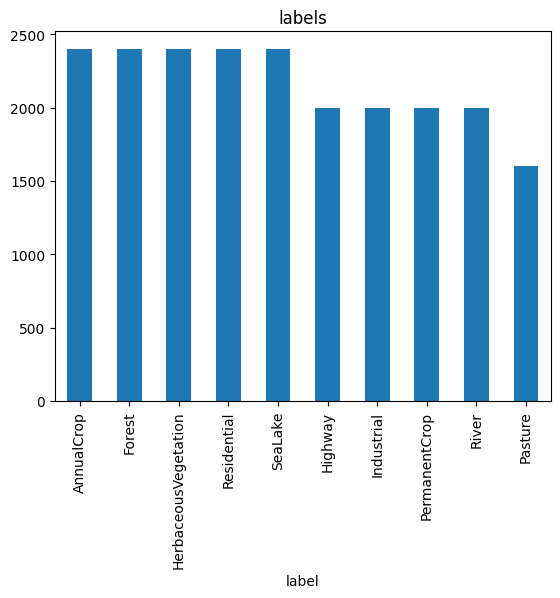

In [8]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(1, 1, 1)
df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('labels')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df.shape, val_df.shape

((17280, 3), (4320, 3))

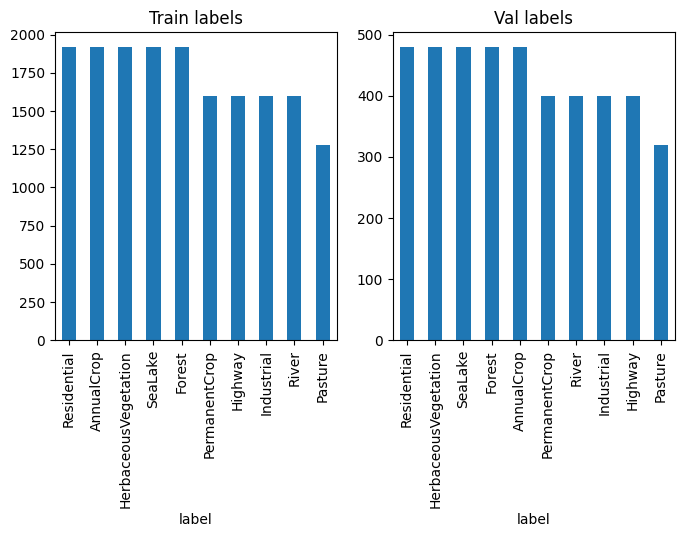

In [10]:
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
train_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Train labels')
ax = plt.subplot(1, 2, 2)
val_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Val labels')
plt.show()

In [11]:
from skimage import io

In [12]:
import torch 
from skimage import io
import numpy as np
from torchvision.transforms import v2


class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, trans):
        self.images = images
        self.labels = labels
        self.trans = trans
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = io.imread(self.images[index])
        label = self.labels[index]
        # print(type(image))
        image = self.trans(image)
        # print(type(image))

        return image.float(), label

In [13]:
from pprint import pprint
import torchvision
import timm

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(classes))
data_config = timm.data.resolve_model_data_config(model)

print("Pretrained model data config:")
pprint(data_config)

train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomApply(
        transforms=[
            v2.RandomAffine(degrees=(0, 10),translate=(0, 0.1),
                            # scale=(0.1, 0.2),
                            # interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                            )
        ], p=0.2,),
    v2.RandomApply(
        transforms=[
            v2.ColorJitter(brightness=.10)
        ], p=0.2,
    ),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    
    # v2.Normalize(mean=data_config["mean"], std=data_config["std"]),
])

pred_transforms = v2.Compose([
    v2.ToTensor(),
    # v2.Normalize(mean=data_config["mean"], std=data_config["std"]),
])

c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pretrained model data config:
{'crop_mode': 'center',
 'crop_pct': 0.95,
 'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225)}


c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [14]:
ds = {
    'train': Dataset(train_df['image'].values, train_df['label_ix'].values, trans=train_transforms),
    'val': Dataset(val_df['image'].values, val_df['label_ix'].values, trans=pred_transforms),
}

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=64, shuffle=False),
}

In [15]:
batch = next(iter(dl['train']))
images, labels = batch

images.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [16]:
images[0].min(), images[0].max()

(tensor(0.2784), tensor(1.))

In [17]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor2 = tensor.detach().clone()
        for t, m, s in zip(tensor2, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor2
# Usando la transformación inversa en tu pipeline
inverse_transform = UnNormalize(mean=data_config["mean"], std=data_config["std"])

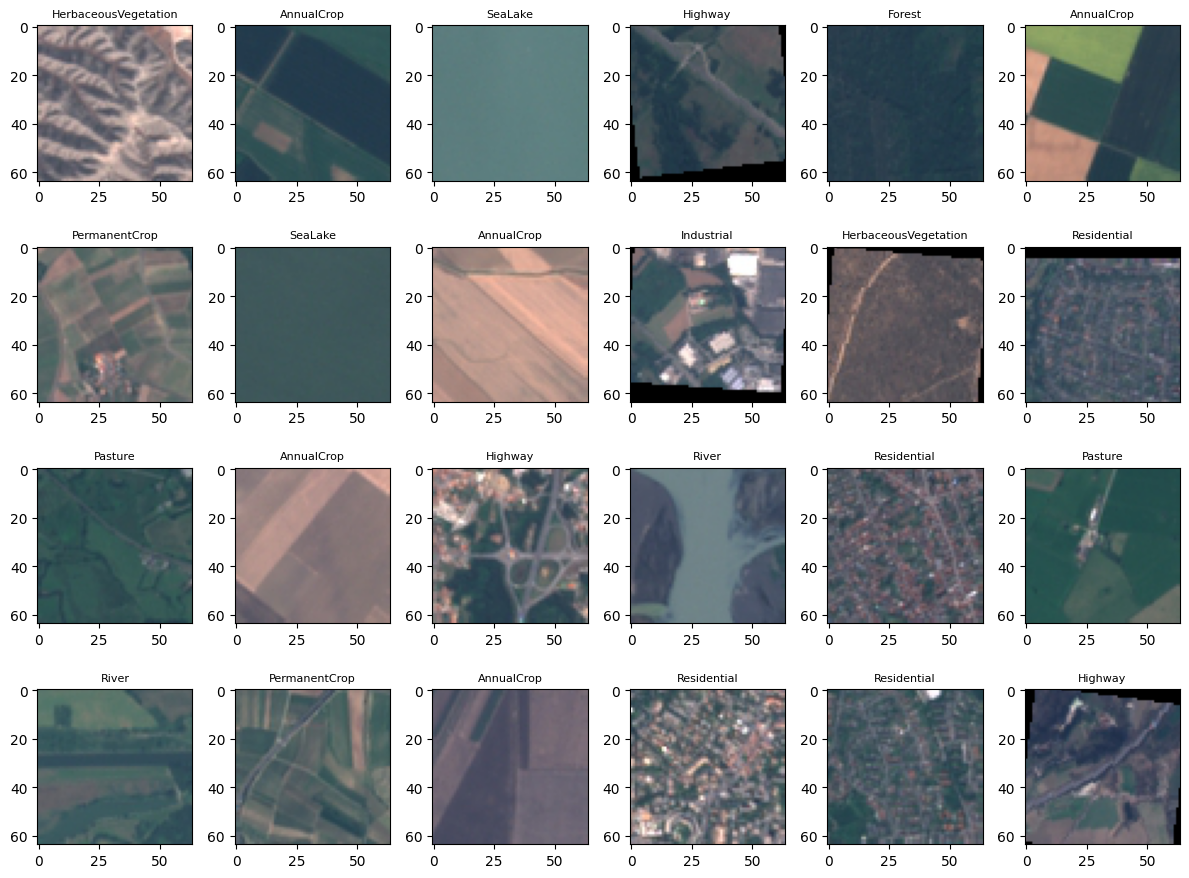

In [18]:
fig = plt.figure(figsize=(12,9))
rows, cols = 4, 6
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    # ax.imshow(images[i])
    # print(images[i].shape)
    # ax.imshow(inverse_transform(images[i]).permute(1,2,0).cpu().numpy())
    ax.imshow(images[i].permute(1,2,0).cpu().numpy())
    ax.set_title(classes[labels[i]], fontsize=8)
    # ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
import timm
import lightning as L
from einops import rearrange

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(classes))
        self.loss_fn = torch.nn.CrossEntropyLoss()	
        self.metric = lambda y_hat, y: torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # return self.model(rearrange(x, 'b h w c -> b c h w'))
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.metric(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc',self.metric(y_hat, y), prog_bar=True)

In [23]:
torch.set_float32_matmul_precision('high')

In [26]:
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="resnet101_scratch")

In [27]:
module = Module()

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=EPOCHS,
    logger=logger,
)

trainer.fit(module, dl['train'], dl['val'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\resnet101_scratch
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | ResNet           | 42.5 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params
170.083   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\Guillermo\miniconda3\envs\cv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 270/270 [01:30<00:00,  2.98it/s, v_num=0, train_acc=0.969, val_acc=0.970]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 270/270 [01:33<00:00,  2.90it/s, v_num=0, train_acc=0.969, val_acc=0.970]


# Visualizing val images predictions

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_1928\107611373.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.nn.functional.softmax(prediction).argmax().item()


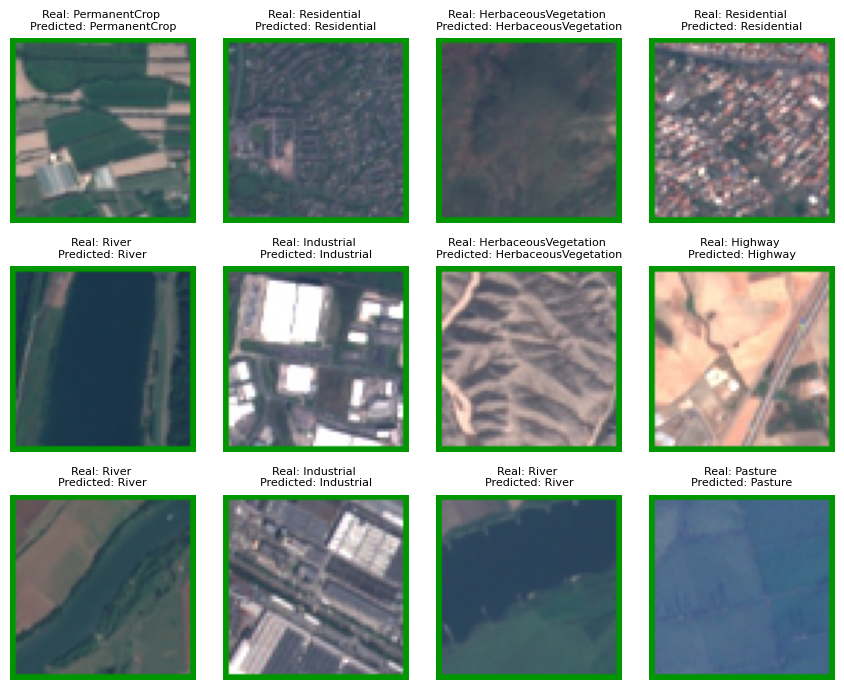

In [163]:
import cv2

batch = next(iter(dl['val']))
images, labels = batch

fig = plt.figure(figsize=(9,7))
rows, cols = 3,4
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    # ax.imshow(inverse_transform(images[i]).permute(1,2,0).cpu().numpy())

    prediction = module.model(images[i][None].to("cuda")).detach().cpu()[0]
    # print(prediction)
    prediction = torch.nn.functional.softmax(prediction).argmax().item()
    prediction = classes[prediction]

    img_plot = (images[i].permute(1,2,0).cpu().numpy().copy()*255).astype(np.uint8)

    if classes[labels[i]] == prediction:
        color = (0,150,0)
    else:
        color = (150,0,0)

    img_plot = cv2.rectangle(img_plot, (0,0), (img_plot.shape[1]-1, img_plot.shape[0]-1), color, 2)

    ax.imshow(img_plot)
    ax.set_title(f"Real: {classes[labels[i]]} \nPredicted: {prediction}", fontsize=8)
    ax.axis('off')
plt.subplots_adjust(hspace=0.4, wspace=0.0)
plt.tight_layout()
plt.show()

# Confusion matrix

In [112]:
from tqdm import tqdm

module.eval()
module.cuda()

with torch.no_grad():
    preds = []
    for img in tqdm(test_images):
        image = io.imread(os.path.join(test_path, img))
        image = pred_transforms(image).unsqueeze(0)
        # print(image.shape)
        pred = module(image.cuda())
        preds.append(classes[torch.argmax(pred).item()])

        # break
assert len(preds) == len(test_images)

100%|██████████| 5400/5400 [01:26<00:00, 62.70it/s]


In [125]:
test_df = pd.DataFrame({'image': test_images, 'label': preds})
test_df

,image,label
0,0000.jpg,AnnualCrop
1,0001.jpg,Industrial
2,0002.jpg,AnnualCrop
3,0003.jpg,Forest
4,0004.jpg,Industrial
...,...,...
5395,5395.jpg,Highway
5396,5396.jpg,Industrial
5397,5397.jpg,Forest
5398,5398.jpg,Forest


In [126]:
submissions_path = Path("./submissions/")
submission_name = SUBMISSION_NAME
test_df.to_csv(submissions_path / submission_name, index=False)

In [127]:
submission = pd.read_csv(submissions_path / submission_name)
submission

,image,label
0,0000.jpg,AnnualCrop
1,0001.jpg,Industrial
2,0002.jpg,AnnualCrop
3,0003.jpg,Forest
4,0004.jpg,Industrial
...,...,...
5395,5395.jpg,Highway
5396,5396.jpg,Industrial
5397,5397.jpg,Forest
5398,5398.jpg,Forest
